# NLP model building with long short term memory LSTM

Purpose : Building a model able to do a classification on sentences

## 0 - Interesting links

* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
* https://www.youtube.com/watch?v=A9QVYOBjZdY&ab_channel=TensorFlow
* https://www.youtube.com/watch?v=ZMudJXhsUpY&ab_channel=TensorFlow

## 1 - Libraries import

In [58]:
import json
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

## 2 - Variables definition

In [59]:
nb_train = 20000 # Number of training examples considered
nb_valid = 5000 # Number of validation examples considered
vocab_size = 10000 # Number of words to be considered regarding on their frequency
max_length = 100 # Maximum length of a sentence --> Size of entrance of neural network
embedding_dim = 32 # Embedding dimension for vector representation of words
nb_epochs = 10 # Number of epochs for training
batch_size = 64 # Number training examples in mini-batches

## 3 - Training JSON file reading

In [60]:
training_examples = []
URL = []
X = [] # sentences
Y = [] # sarcastic or not

for line in open('sarcasm_training_dataset.json', 'r'):
    training_examples.append(json.loads(line))

for item in training_examples:
    X.append(item['headline'])
    Y.append(item['is_sarcastic'])
    URL.append(item['article_link'])

## 4 - Training / Test dataset splitting

In [61]:
X_train = X[0:nb_train]
Y_train = Y[0:nb_train]

X_valid = X[nb_train:nb_train + nb_valid]
Y_valid = Y[nb_train:nb_train + nb_valid]

X_test = X[nb_train + nb_valid:]
Y_test = Y[nb_train + nb_valid:]

## 5 - Sentences tokenization

In [62]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words = vocab_size) # Strategy for considering Out Of Vocabulary words
tokenizer.fit_on_texts(X_train) # Only considering words in training examples
word_index = tokenizer.word_index

# Pre-processing training set:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing validation set:
X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing test set:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length, padding = 'post', truncating = 'post')

## 6 - Model architecture definition

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.4, recurrent_dropout = 0.4, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 32)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         49664     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

## 7 - Model training

In [69]:
callback_list = []

callback_list.append(EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.0, mode = 'min')) # Callback to ensure parameters update in accordance with test accuracy improvement
callback_list.append(CSVLogger('training_log.csv')) # Callback to get a feedback

In [70]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

history = model.fit(X_train, Y_train, epochs = nb_epochs, batch_size = batch_size, validation_data = (X_valid, Y_valid), verbose = 2, callbacks = callback_list)

Epoch 1/10
313/313 - 160s - loss: 0.2110 - accuracy: 0.9162 - val_loss: 0.3397 - val_accuracy: 0.8584
Epoch 2/10
313/313 - 161s - loss: 0.1702 - accuracy: 0.9348 - val_loss: 0.3615 - val_accuracy: 0.8566
Epoch 3/10
313/313 - 161s - loss: 0.1412 - accuracy: 0.9463 - val_loss: 0.3926 - val_accuracy: 0.8488
Epoch 4/10
313/313 - 160s - loss: 0.1222 - accuracy: 0.9540 - val_loss: 0.4584 - val_accuracy: 0.8452
Epoch 5/10
313/313 - 154s - loss: 0.1159 - accuracy: 0.9563 - val_loss: 0.4252 - val_accuracy: 0.8500
Epoch 6/10
313/313 - 141s - loss: 0.0957 - accuracy: 0.9643 - val_loss: 0.4855 - val_accuracy: 0.8442


## 8 - Model training analysis

### 8.1 - Accuracy & Loss plots

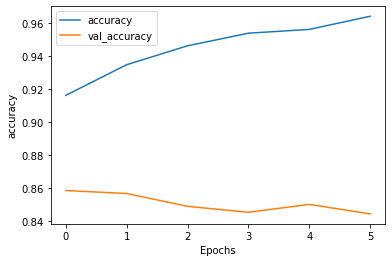

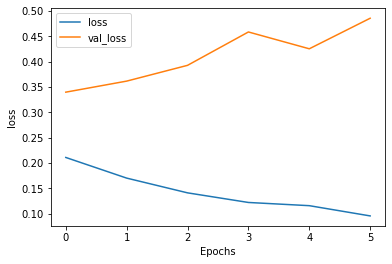

In [71]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 8.2 - Loading log file information

In [72]:
df_log = pd.read_csv('training_log.csv')
df_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.91625,0.210962,0.8584,0.339707
1,1,0.93485,0.170249,0.8566,0.361498
2,2,0.94635,0.141184,0.8488,0.392598
3,3,0.95400,0.122221,0.8452,0.458392
4,4,0.95630,0.115898,0.8500,0.425226
5,5,0.96430,0.095701,0.8442,0.485459


## 9 - Predictions on test set & new sentences

In [73]:
Y_test_prediction = np.round_(model.predict(X_test)[:,0])
conf_matrix = confusion_matrix(Y_test_prediction, Y_test)

print('CONFUSION MATRIX' + '\n' + '='*20)
print('TRUE POSITIVES : ' + str(conf_matrix[0][0]) + '\nFALSE POSITIVES : ' + str(conf_matrix[0][1]) + '\nFALSE NEGATIVES : ' + str(conf_matrix[1][0]) + '\nTRUE NEGATIVES : ' + str(conf_matrix[1][1]))
print('-'*20 + '\nACCURACY : ' + str(np.round_(100 * (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][0] + conf_matrix[0][1] + conf_matrix[1][1]),2)) + ' %')

CONFUSION MATRIX
TRUE POSITIVES : 862
FALSE POSITIVES : 185
FALSE NEGATIVES : 101
TRUE NEGATIVES : 561
--------------------
ACCURACY : 83.27 %


In [74]:
sentence = ["granny starting to fear spiders in the garden might be real"]
sequence = tokenizer.texts_to_sequences(sentence)
sentence = pad_sequences(sequence, maxlen = max_length, padding = 'post', truncating = 'post')

print(np.round_(model.predict(sentence)))

[[1.]]


## 10 - Model parameters save 

In [75]:
model.save("seq_model.h5")

## 11 - Saved model loading

In [76]:
model = load_model('seq_model.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 32)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         49664     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               